# Introduction to GraphBLAS with Python

The GraphBLAS is an API for [sparse matrix](https://en.wikipedia.org/wiki/Sparse_matrix) and vector operations to solve graph problems using [Linear Algebra](https://en.wikipedia.org/wiki/Linear_algebra).  pygraphblas wraps the GraphBLAS API using [CFFI](https://cffi.readthedocs.io/en/latest/).  This notebook is an introduction to the GraphBLAS and also tutorial on how work with graphs in Python using the pygraphblas library.

For an mathematical introduction see [Mathematical Foundations of the GraphBLAS](https://people.eecs.berkeley.edu/~aydin/GraphBLAS-Math.pdf).

There are several examples of common algorithms implemented with pygraphblas:

 - [PageRank](./PageRank.ipynb)
 - [Betweeness Centrality](./BetweenessCentrality.ipynb)
 - [K-Truss Subgraphs](./K-Truss.ipynb)
 - [Triangle Counting](./Triangle-Counting.ipynb)
 - [RadiX-Net Topologies](./RadiX-Net-with-pygraphblas.ipynb)
 - [User Defined Types](./User-Defined-Types.ipynb)
 - [Log Semiring](./Log-Semiring.ipynb)

The follow is a brief introduction to some of pygraphblas' features.  Over time the goal will be to improve the documentation and examples.  For any suggestions, please [open an issue](https://github.com/michelp/pygraphblas/issues) so we can discuss it.

## Matrices can represent Graphs

The key concept of the GraphBLAS is that [a matrix can represent a graph](https://en.wikipedia.org/wiki/Adjacency_matrix) and [Linear Algebra](https://en.wikipedia.org/wiki/Linear_algebra) can be used to operate on graph matrices.  In the conventional sense, a graph is a set of nodes that have edges connecting them.  The same connectivity can be represented as a matrix where edges are weight value at the intersection of rows and columns.  The rows represent the outgoing node, and the column represents the incoming node.

By relying on the mathmatical foundations of graph theory and abstract algebra, graph problems can be expressed in a closed, composible algebraic language. Instead of thinking of problems node and edge at a time, GraphBLAS encourages you to think of and operate on the graph as a whole object using well understood mathmatical techniques.

For expedience we'll import the entire pygraphblas library into this notebook with `import *`.  This is normally not a recommended practice.  This won't effect the examples here but keep it in mind.

In [1]:
from pygraphblas import *
from pygraphblas.demo.gviz import draw, draw_op

Matrices can be created several different ways, for example literal lists of data can be used to construct them, as shown here from three lists, a list of outgoing nodes, a list of incoming nodes, and a list of weights.  The first two lists must be integers, and pygraphblas automatically makes a matrix of the correct type based on the type of the values in the third list, in this case, integers as well:

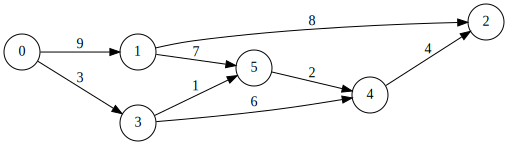

In [2]:
A = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 1, 5],
    [1, 3, 2, 4, 5, 2, 5, 4],
    [9, 3, 8, 6, 1, 4, 7, 2],)

draw(A)

## Adding Matrices

Adding two matrices with the plus operator (`+`) causes the two graphs to be combined together in a union of their shapes, a combining operator is used when both operands have an edge in common.  The default operator is `graphblas.plus` which adds the two weights, but there are many binary operators in GraphBLAS that can be used.

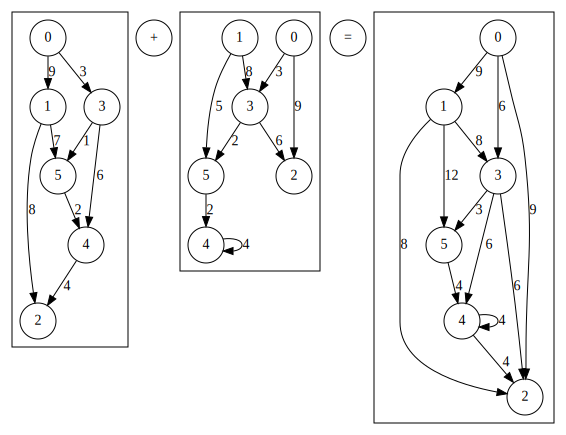

In [3]:
B = Matrix.from_lists(
    [0, 0, 1, 3, 3, 4, 1, 5],
    [2, 3, 3, 2, 5, 4, 5, 4],
    [9, 3, 8, 6, 2, 4, 5, 2],)

C = A + B
draw_op(A, '+', B, C)

## Using a different operator

To specify a different combining operator when elementwise addition, you can use the `with` syntax, inside this with block the specified operator is used.

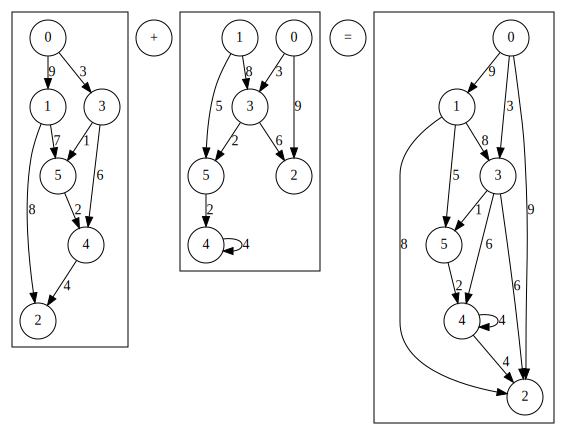

In [4]:
with binaryop.MIN:
    C = A + B
draw_op(A, '+', B, C)

## Elementwise Multiplication

Multiplying two with the star operator (`*`) does elementwise multiplication, which returns only the intersection of common edges in the two graphs.  Note how this contrasts with elementwise addition above which takes the union.  Only the edges in common between the two graphs are operated on.  The default operator is `graphblas.times` which multiples their values.

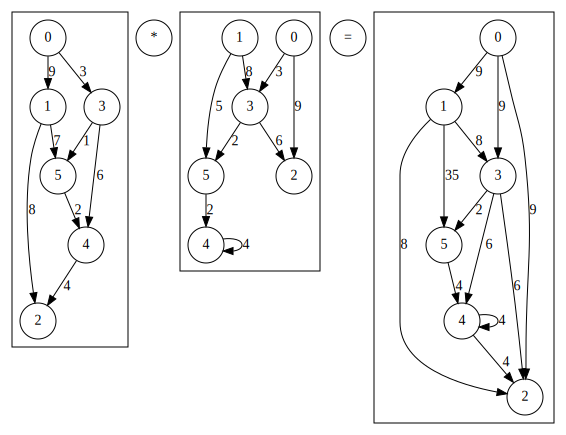

In [5]:
C = A * B
draw_op(A, '*', B, C)

## Elementwise Multiplication using different operators

Like addition, elementwise multiplication can use different operators using `with` syntax.

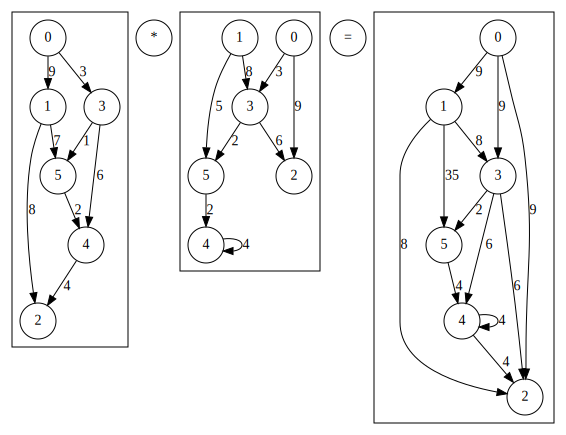

In [6]:
with binaryop.MIN:
    C = A * B

draw_op(A, '*', B, C)

## Matrix Vector multiplication

Matrices can be multiplied on the right by vectors, this is similar to taking a step "backwards" in a Breadth First Search from nodes specified in the right operand.  The type of the output is the same as the left operand.

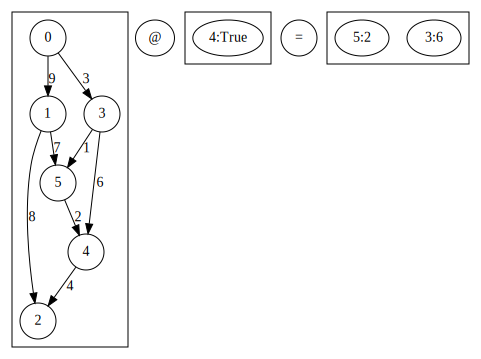

In [7]:
v = Vector.from_lists([4],[True], A.nrows)

draw_op(A, '@', v, A @ v)

In order to search forward through a graph doing matrix vector multiplication, then use the transpose of the input matrix:

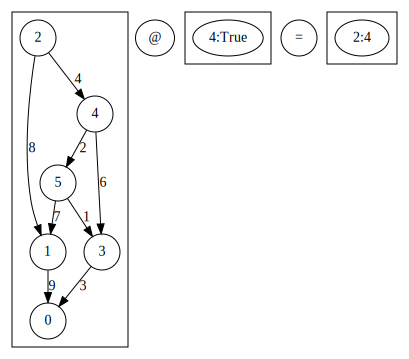

In [8]:
draw_op(A.transpose(), '@', v, A.transpose() @ v)

## Vector Matrix Multiplication

A Vector can be multiplied on the left by a matrix.  This is a fundamental "step" in a Breadth First Search (BFS) across the graph, the result are the adjacent edges to the input.  This is mathematically identical to the operation `A.tranpose() @ v` shown above.  Note that the type of the result is that same as the left operand, in this case boolean:

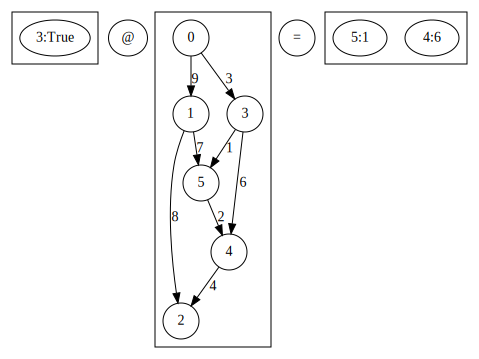

In [9]:
v = Vector.from_lists([3],[True], A.nrows)

y = v @ A
draw_op(v, '@', A, y)

## Row vs Column Vector Matrix Multiplication

`Av == vA'` so which direction to go depends on your style and problem.  But it's good to keep in mind these equivalents:

In [10]:
(A @ v == v @ A.transpose()).reduce_bool() and (v @ A == A.transpose() @ v).reduce_bool()

True

## Matrix Multiplication

The matrix multiplication operator (`@`) is also used to multiply two matrices.  The common data pattern is multiplying the rows of the left operand by the columns of the right operand and then summing the results.  In the results below the `A` matrix will be multiplied by itself.  This squaring of an adjacency matrix is often used to find the [Friend of a Friend](https://en.wikipedia.org/wiki/Friend_of_a_friend) graph, where the result's edges join nodes to nodes two steps away:

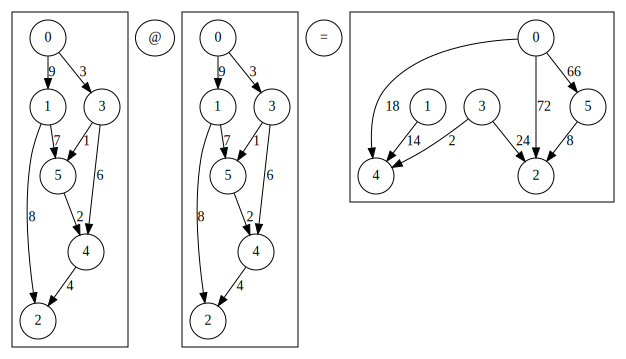

In [11]:
draw_op(A, '@', A, A @ A)

## Semirings

A different [Semiring](https://en.wikipedia.org/wiki/Semiring) can be used during matrix multiplication to get different results. A semiring defines two binary operators that are substituted for the multiplication "inner" matrix multiply operation and the addition "outer" operation.  In the next example uses the `min_plus` semiring.

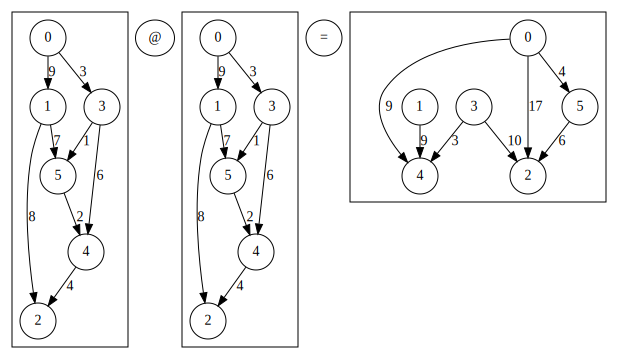

In [12]:
with semiring.MIN_PLUS:
    g = draw_op(A, '@', A, A @ A)
g

## Transpose

A matrix can be transposed with the `transpose()` method.  This effectively reverses the direction of edges in a graph.

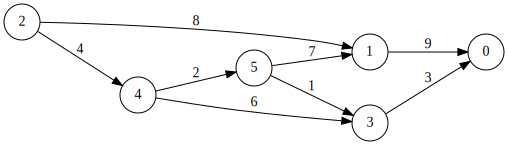

In [13]:
draw(A.transpose())

## Symmetric Graphs

Adding a graph to it's transpose makes its symmetric, every edge has a corresponding reverse edge.

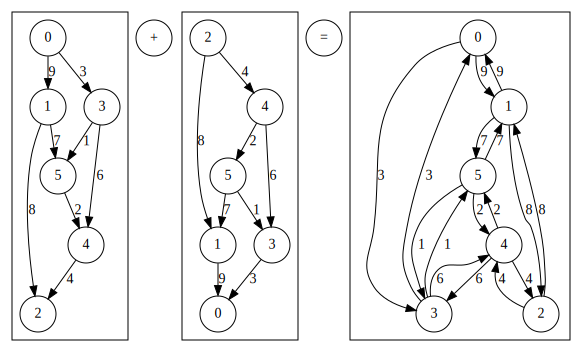

In [14]:
draw_op(A, '+', A.transpose(), A + A.transpose())

## Random Graphs

Random graphs can be constructed with the `random` Matrix class method.

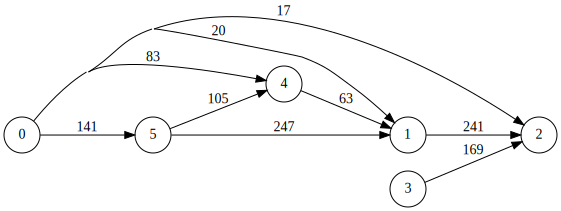

In [15]:
draw(Matrix.random(UINT8, 6,6,10, no_diagonal=True, seed=42), show_weight=True)

## Breadth First Search

Matrix multiplication is the basic operation for taking a step across a graph.  This single movement can be combined with a loop to step across an entire graph, tracking the distance from a beginning node to every other node in the graph.  This is called a *Breadth First Search*.

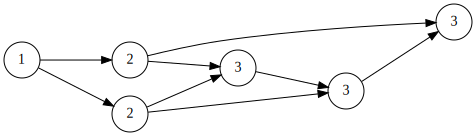

In [21]:
def bfs(matrix, start):
    """Given a graph and a starting position, return a vector of hops to all other nodes."""
    v = Vector.sparse(UINT8, matrix.nrows)   # the result vector
    q = Vector.sparse(BOOL, matrix.nrows)    # a vector to keep track of known nodes
    
    q[start] = True
    level = 1
    
    while q.reduce_bool() and level <= matrix.nrows:
        v.assign_scalar(level, mask=q)          # Assign the current level to known (q) nodes in v
        v.vxm(matrix, mask=v, out=q,
                  desc=descriptor.oocr)         # compliment the mask only find the next unknown nodes
        level += 1                              # increment level
    return v
    
draw(A, show_weight=False, label_vector=bfs(A, 0))

## Shortest Path Length

Using the `min_plus` semiring a similar approach can be used to find the shortest path length between two nodes.  Note how instead of a mask/reduce operation, an equality comparison `iseq` is used to determine if a vector changes from one operation to the next.

This simple algorithm only returns the shortest path length.  Often it's helpful to also compute the actual path and count the number of hops as well.  This is demonstrated in the [User Defined Types](./User-Defined-Types.ipynb) notebook.

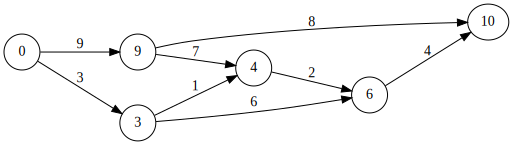

In [17]:
def shortest_path_length(matrix, start):
    v = Vector.sparse(matrix.type, matrix.nrows)
    v[start] = 0

    with semiring.MIN_PLUS, Accum(binaryop.MIN):
        for _ in range(matrix.nrows):
            w = Vector.dup(v)
            v @= matrix
            if w.iseq(v):
                break
        return v

draw(A, label_vector=shortest_path_length(A, 0))

In [18]:
v = Vector.sparse(A.type, A.nrows)
v[0] = 0
with semiring.MIN_PLUS, Accum(binaryop.MIN):
    C = v ** A
draw(A, label_vector=C)

TypeError: unsupported operand type(s) for ** or pow(): 'Vector' and 'Matrix'